In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

import npc_lims
import npc_ephys
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

from brainbox.metrics import single_units

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\one\alf\files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [ ]:
# from brainbox.metrics import single_units

In [2]:
# load a session
session_id='668755_2023-08-30'

session = DynamicRoutingSession(session_id)
session_info=npc_lims.get_session_info(session.id)
# trials=data_utils.load_trials_or_units(session,'trials')
# units=data_utils.load_trials_or_units(session,'units')

# # print areas recorded
# units['structure'].unique()


In [3]:
si = npc_ephys.SpikeInterfaceKS25Data(session_info.id)

In [4]:
# si.quality_metrics_df(probe='A')
# amplitudes_path=si.get_correct_path(si.postprocessed(probe='A'),"spike_amplitudes","amplitude_segment_0.npy")

unit_index=si.unit_indexes(probe='A') #the unit INDEX of each spike
unique_unit_indices=np.unique(unit_index)
cluster_id=si.original_cluster_id(probe='A') #the original cluster id of each unit

# si.spike_indexes(probe='A') #the sample index of each spike?

In [5]:
amplitudes_path=r"D:\temp_session_data\amplitude_segment_0.npy"
amplitudes=np.load(amplitudes_path)
amplitudes

array([-189.54    , -182.51999 ,  -95.939995, ...,  -42.12    ,
        -70.2     , -163.79999 ], dtype=float32)

In [7]:
sel_probe='probeA'
sel_unit_idx=0

sel_unit_amplitudes=amplitudes[unit_index==sel_unit_idx]
sel_unit_cluster_id=cluster_id[sel_unit_idx]

sel_unit=units.query('cluster_id==@sel_unit_cluster_id and electrode_group_name==@sel_probe')



In [8]:
sel_unit_idx=0
sel_unit=units.iloc[sel_unit_idx]
sel_unit_cluster_id=sel_unit['cluster_id']
sel_unit_cluster_idx=np.where(cluster_id==sel_unit_cluster_id)[0][0]
sel_unit_amplitudes=amplitudes[unit_index==sel_unit_cluster_idx]

In [9]:
sel_unit_amplitudes

array([ -77.21999 ,  -84.24    ,  -95.939995, ..., -161.45999 ,
        -79.56    , -126.35999 ], dtype=float32)

In [10]:
nc_pass, cutoff, first_low_quantile = single_units.noise_cutoff(sel_unit_amplitudes, quantile_length=.25, n_bins=100, nc_threshold=5, percent_threshold=0.10)

In [157]:
sel_unit

285

In [148]:
# units.query('cluster_id==@sel_unit_cluster_id and electrode_group_name==@sel_probe')

In [ ]:
#save units, trials, etc.
savepath=r"D:\temp_session_data"
units.to_pickle(os.path.join(savepath,str(session_id)+'_units.pkl'))
trials.to_pickle(os.path.join(savepath,str(session_id)+'_trials.pkl'))


In [6]:
#load units, trials
loadpath=r"D:\temp_session_data"
session_id='668755_2023-08-30'
units=pd.read_pickle(os.path.join(loadpath,str(session_id)+'_units.pkl'))
trials=pd.read_pickle(os.path.join(loadpath,str(session_id)+'_trials.pkl'))
# amplitudes=pd.read_pickle(os.path.join(loadpath,str(session_id)+'_amplitudes.pkl'))

In [127]:
units.query('electrode_group_name=="probeA"')['cluster_id'].unique().shape

(813,)

In [128]:
# units[['electrode_group_name','cluster_id']]
# units.columns

In [ ]:
sel_unit=units.iloc[0]
sel_unit

(1603,
 amplitude_cutoff                                                 0.000263
 amplitude_cv_median                                                   NaN
 amplitude_cv_range                                                    NaN
 amplitude_median                                                    128.7
 drift_ptp                                                       20.078735
 drift_std                                                        4.740824
 drift_mad                                                        4.914656
 firing_range                                                         13.8
 firing_rate                                                      4.440147
 isi_violations_ratio                                                  0.0
 isi_violations_count                                                  0.0
 num_spikes                                                        28844.0
 presence_ratio                                                   0.916667
 rp_contamination 

In [11]:
#compute ibl metrics

probe_units=units.query('electrode_group_name=="probeA"')

# ibl_contamination = []
# ibl_missed_spikes = []
unit_pass_sliding_rp=[]
unit_noise_cutoff=[]
unit_noise_cutoff_pass=[]
unit_noise_cutoff_first_low_quantile=[]

for uu,sel_unit in probe_units.iterrows():
    #sliding rp violation
    unit_pass_sliding_rp.append(single_units.slidingRP_viol(sel_unit['spike_times'], bin_size=0.25, thresh=0.1, acceptThresh=0.1))
    
    #single_units.noise_cutoff
    sel_unit_cluster_id=sel_unit['cluster_id']
    sel_unit_cluster_idx=np.where(cluster_id==sel_unit_cluster_id)[0][0]
    sel_unit_amplitudes=np.abs(amplitudes[unit_index==sel_unit_cluster_idx])

    nc_pass, cutoff, first_low_quantile = single_units.noise_cutoff(sel_unit_amplitudes, quantile_length=.25, n_bins=100, nc_threshold=5, percent_threshold=0.10)
    unit_noise_cutoff_pass.append(nc_pass)
    unit_noise_cutoff.append(cutoff)
    unit_noise_cutoff_first_low_quantile.append(first_low_quantile)

probe_units['ibl_sliding_rp']=unit_pass_sliding_rp
probe_units['ibl_noise_cutoff']=unit_noise_cutoff
probe_units['ibl_noise_cutoff_pass']=unit_noise_cutoff_pass
probe_units['ibl_noise_cutoff_first_low_quantile']=unit_noise_cutoff_first_low_quantile

#single_units.noise_cutoff
# single_units.noise_cutoff(amps, quantile_length=.25, n_bins=100, nc_threshold=5, percent_threshold=0.10)


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20648\3123984380.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probe_units['ibl_sliding_rp']=unit_pass_sliding_rp
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20648\3123984380.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probe_units['ibl_noise_cutoff']=unit_noise_cutoff
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20648\3123984380.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

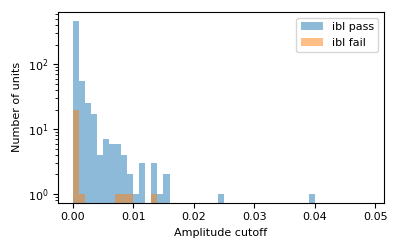

In [12]:
#plot noise cutoff pass/fail comp to amplitude cutoff
xbins=np.arange(0,0.05,0.001)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['amplitude_cutoff'][probe_units['ibl_noise_cutoff_pass']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['amplitude_cutoff'][probe_units['ibl_noise_cutoff_pass']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
#set y logscale
ax.set_yscale('log')
ax.set_xlabel('Amplitude cutoff')
ax.set_ylabel('Number of units')
fig.tight_layout()

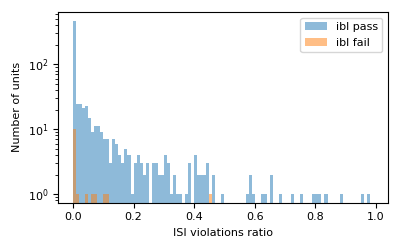

In [63]:
#plot noise cutoff pass/fail comp to amplitude cutoff
xbins=np.arange(0,1,0.01)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['isi_violations_ratio'][probe_units['ibl_noise_cutoff_pass']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['isi_violations_ratio'][probe_units['ibl_noise_cutoff_pass']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
#set y logscale
ax.set_yscale('log')
ax.set_xlabel('ISI violations ratio')
ax.set_ylabel('Number of units')
fig.tight_layout()

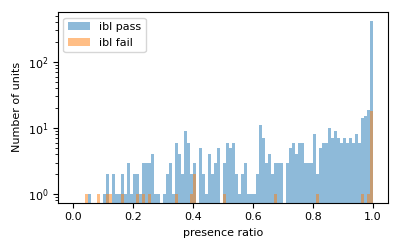

In [64]:
#plot noise cutoff pass/fail comp to amplitude cutoff
xbins=np.arange(0,1.01,0.01)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['presence_ratio'][probe_units['ibl_noise_cutoff_pass']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['presence_ratio'][probe_units['ibl_noise_cutoff_pass']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
#set y logscale
ax.set_yscale('log')
ax.set_xlabel('presence ratio')
ax.set_ylabel('Number of units')
fig.tight_layout()

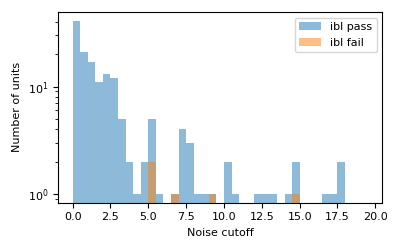

In [38]:
#plot noise cutoff pass/fail comp to amplitude cutoff
xbins=np.arange(0,20,0.5)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['ibl_noise_cutoff'][probe_units['ibl_noise_cutoff_pass']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['ibl_noise_cutoff'][probe_units['ibl_noise_cutoff_pass']==0],bins=xbins,label='ibl fail',alpha=0.5)
# ax.hist(probe_units['ibl_noise_cutoff_first_low_quantile'][probe_units['ibl_noise_cutoff_pass']==1],bins=xbins,label='ibl pass',alpha=0.5)
# ax.hist(probe_units['ibl_noise_cutoff_first_low_quantile'][probe_units['ibl_noise_cutoff_pass']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
#set y logscale
ax.set_yscale('log')
ax.set_xlabel('Noise cutoff')
ax.set_ylabel('Number of units')
fig.tight_layout()

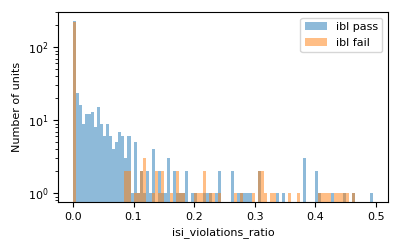

In [13]:
#plot sliding_rp pass/fail comp to isi_violations_ratio
xbins=np.arange(0,0.5,0.005)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['isi_violations_ratio'][probe_units['ibl_sliding_rp']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['isi_violations_ratio'][probe_units['ibl_sliding_rp']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('isi_violations_ratio')
ax.set_ylabel('Number of units')
fig.tight_layout()

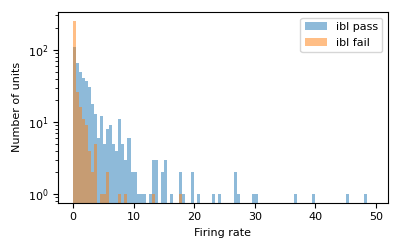

In [67]:
#plot distributions of firing rate according to ibl pass/fail
xbins=np.arange(0,50,0.5)

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['firing_rate'][probe_units['ibl_sliding_rp']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['firing_rate'][probe_units['ibl_sliding_rp']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('Firing rate')
ax.set_ylabel('Number of units')
fig.tight_layout()


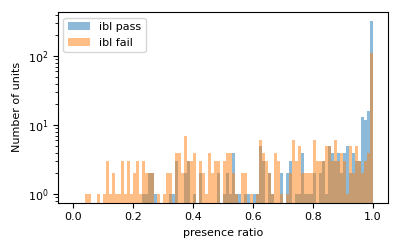

In [48]:
#plot distributions of presence_ratio according to ibl pass/fail
xbins=np.arange(0,1.01,0.01)

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['presence_ratio'][probe_units['ibl_sliding_rp']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['presence_ratio'][probe_units['ibl_sliding_rp']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('presence ratio')
ax.set_ylabel('Number of units')
fig.tight_layout()


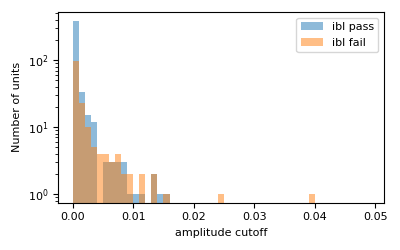

In [51]:
#plot distributions of amplitude_cutoff according to ibl pass/fail
xbins=np.arange(0,0.05,0.001)

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['amplitude_cutoff'][probe_units['ibl_sliding_rp']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['amplitude_cutoff'][probe_units['ibl_sliding_rp']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('amplitude cutoff')
ax.set_ylabel('Number of units')
fig.tight_layout()


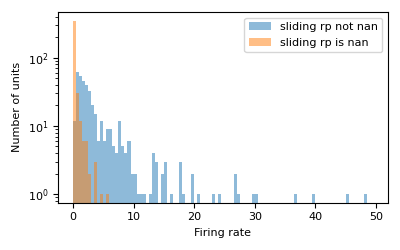

In [15]:
#plot distributions of firing rate according to ibl pass/fail
xbins=np.arange(0,50,0.5)

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['firing_rate'][~np.isnan(probe_units['sliding_rp_violation'])],bins=xbins,label='sliding rp not nan',alpha=0.5)
ax.hist(probe_units['firing_rate'][np.isnan(probe_units['sliding_rp_violation'])],bins=xbins,label='sliding rp is nan',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('Firing rate')
ax.set_ylabel('Number of units')
fig.tight_layout()


In [ ]:
np.mean()

In [175]:
# bins_list

In [17]:
np.mean((probe_units['ibl_sliding_rp']==1)&(probe_units['ibl_noise_cutoff_pass']==1)&(probe_units['amplitude']>=50))

0.5793357933579336

In [18]:
np.mean((units['isi_violations_ratio']<0.5)&(units['amplitude_cutoff']<0.1)&(units['presence_ratio']>=0.9))

0.5297532656023222

In [19]:
np.mean((units['isi_violations_ratio']<0.1)&(units['amplitude_cutoff']<0.1)&(units['presence_ratio']>=0.99))

0.3497822931785196

Text(0.5, 1.0, 'Fraction of units passing different criteria')

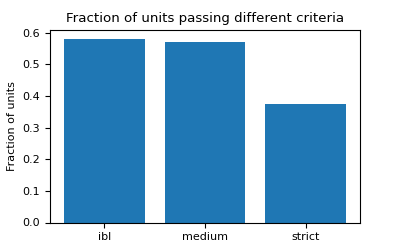

In [44]:
#fraction units passing different criteria
ibl_criteria=np.mean((probe_units['ibl_sliding_rp']==1)&(probe_units['ibl_noise_cutoff_pass']==1)&(probe_units['amplitude']>=50))
medium_criteria=np.mean((probe_units['isi_violations_ratio']<0.5)&(probe_units['amplitude_cutoff']<0.1)&(probe_units['presence_ratio']>=0.9))
strict_criteria=np.mean((probe_units['isi_violations_ratio']<0.1)&(probe_units['amplitude_cutoff']<0.1)&(probe_units['presence_ratio']>=0.99))
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(['ibl','medium','strict'],[ibl_criteria,medium_criteria,strict_criteria])
ax.set_ylabel('Fraction of units')
ax.set_title('Fraction of units passing different criteria')


In [23]:
# np.isnan(units['ibl_sliding_rp']).mean()
# np.mean(units['ibl_sliding_rp'][np.isnan(units['sliding_rp_violation'])])

In [6]:
num_violations

0

In [196]:
np.mean(units['isi_violations_ratio']<=0.1)

0.7317851959361393

In [46]:
np.mean(units['sliding_rp_violation']<=0.1)

0.3602322206095791

(array([429., 147.,  84.,  57.,  27.,  27.,  25.,  21.,  13.,   5.,   4.,
          6.,   4.,   7.,   4.,   5.,   2.,   2.,   1.,   0.,   2.,   2.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049]),
 <BarContainer object of 49 artists>)

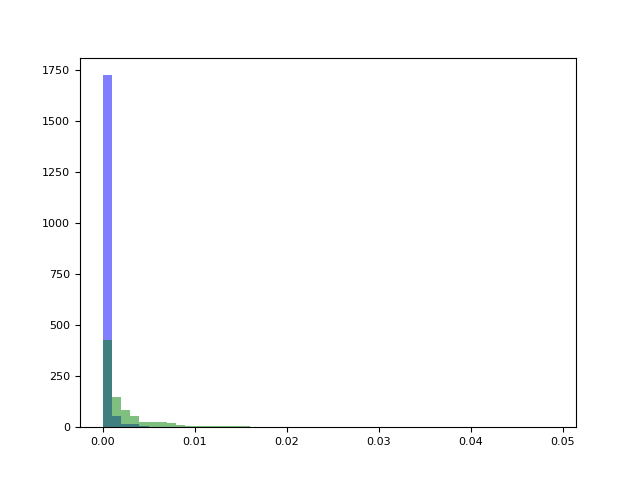

In [24]:
isnan_ind=np.isnan(units['sliding_rp_violation'])

# xbins=np.arange(0,0.4,0.01) #isi_viol
# xbins=np.arange(0,20,0.5) #fr
# xbins=np.arange(0,1.01,0.01) #presence_ratio
xbins=np.arange(0,0.05,0.001) #amplitude_cutoff

fig,ax=plt.subplots(1,1)
ax.hist(units['amplitude_cutoff'][~isnan_ind],bins=xbins,alpha=0.5,color='b')
ax.hist(units['amplitude_cutoff'][isnan_ind],bins=xbins,alpha=0.5,color='g')

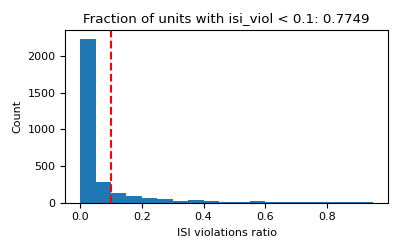

In [54]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,1,0.05) #amplitude

frac_below_10=np.mean(probe_units['isi_violations_ratio']<0.1)

ax.axvline(0.1,linestyle='--',color='r')
ax.hist(units['isi_violations_ratio'],bins=xbins)
ax.set_title('Fraction of units with isi_viol < 0.1: '+str(np.round(frac_below_10,decimals=4)))
ax.set_xlabel('ISI violations ratio')
ax.set_ylabel('Count')
fig.tight_layout()

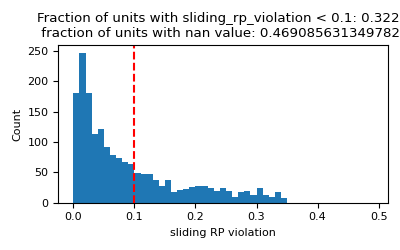

In [55]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,0.5,0.01) #amplitude

frac_below_10=np.mean(probe_units['sliding_rp_violation']<0.1)

ax.axvline(0.1,linestyle='--',color='r')
ax.hist(units['sliding_rp_violation'],bins=xbins)
ax.set_title('Fraction of units with sliding_rp_violation < 0.1: '+str(np.round(frac_below_10,decimals=4))+
             '\n fraction of units with nan value: '+str(np.mean(np.isnan(units['sliding_rp_violation']))))
ax.set_xlabel('sliding RP violation')
ax.set_ylabel('Count')
fig.tight_layout()

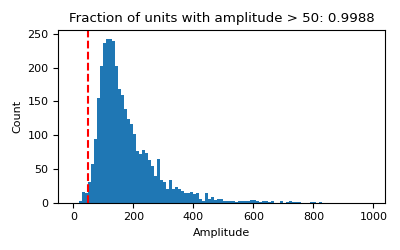

In [56]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,1000,10) #amplitude

frac_above_50=np.mean(probe_units['amplitude']>50)

ax.axvline(50,linestyle='--',color='r')
ax.hist(units['amplitude'],bins=xbins)
ax.set_title('Fraction of units with amplitude > 50: '+str(np.round(frac_above_50,decimals=4)))
ax.set_xlabel('Amplitude')
ax.set_ylabel('Count')
fig.tight_layout()

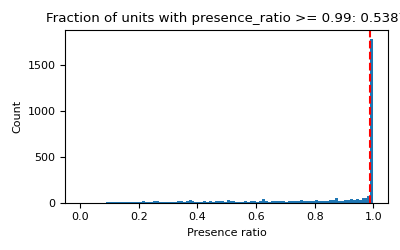

In [59]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,1.01,0.01) #amplitude

frac_above_99=np.mean(probe_units['presence_ratio']>=0.99)

ax.axvline(0.99,linestyle='--',color='r')
ax.hist(units['presence_ratio'],bins=xbins)
ax.set_title('Fraction of units with presence_ratio >= 0.99: '+str(np.round(frac_above_99,decimals=4)))
ax.set_xlabel('Presence ratio')
ax.set_ylabel('Count')
fig.tight_layout()

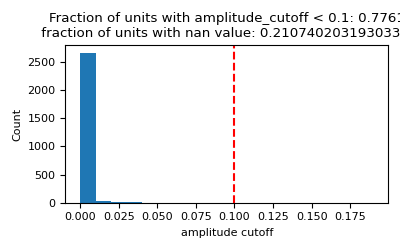

In [61]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,0.2,0.01) #amplitude

frac_below_01=np.mean(probe_units['amplitude_cutoff']<0.1)

ax.axvline(0.1,linestyle='--',color='r')
ax.hist(units['amplitude_cutoff'],bins=xbins)
ax.set_title('Fraction of units with amplitude_cutoff < 0.1: '+str(np.round(frac_below_01,decimals=4))+
             '\n fraction of units with nan value: '+str(np.mean(np.isnan(units['amplitude_cutoff']))))
ax.set_xlabel('amplitude cutoff')
ax.set_ylabel('Count')
fig.tight_layout()

In [ ]:
# fig,ax=plt.subplots(1,1,figsize=(4,2.5))

# xbins=np.arange(0,0.2,0.01) #amplitude

# frac_below_01=np.mean(probe_units['ibl_sliding_rp']==1)

# ax.axvline(0.1,linestyle='--',color='r')
# ax.hist(probe_units['amplitude_cutoff'],bins=xbins)
# ax.set_title('Fraction of units with amplitude_cutoff < 0.1: '+str(np.round(frac_below_01,decimals=4))+
#              '\n fraction of units with nan value: '+str(np.mean(np.isnan(probe_units['amplitude_cutoff']))))
# ax.set_xlabel('amplitude cutoff')
# ax.set_ylabel('Count')
# fig.tight_layout()

In [ ]:
## directly compare IBL and SI implementations of RP viol metric

In [135]:
### IBL function:
from phylib.stats import correlograms
import scipy.stats as stats

def slidingRP_viol_IBL(ts, bin_size=0.25, thresh=0.1, acceptThresh=0.1):
    """
    A binary metric which determines whether there is an acceptable level of
    refractory period violations by using a sliding refractory period:

    This takes into account the firing rate of the neuron and computes a
    maximum acceptable level of contamination at different possible values of
    the refractory period. If the unit has less than the maximum contamination
    at any of the possible values of the refractory period, the unit passes.

    A neuron will always fail this metric for very low firing rates, and thus
    this metric takes into account both firing rate and refractory period
    violations.


    Parameters
    ----------
    ts : ndarray_like
        The timestamps (in s) of the spikes.
    bin_size : float
        The size of binning for the autocorrelogram.
    thresh : float
        Spike rate used to generate poisson distribution (to compute maximum
              acceptable contamination, see _max_acceptable_cont)
    acceptThresh : float
        The fraction of contamination we are willing to accept (default value
              set to 0.1, or 10% contamination)

    Returns
    -------
    didpass : int
        0 if unit didn't pass
        1 if unit did pass

    See Also
    --------
    contamination

    Examples
    --------
    1) Compute whether a unit has too much refractory period contamination at
    any possible value of a refractory period, for a 0.25 ms bin, with a
    threshold of 10% acceptable contamination
        >>> ts = units_b['times']['1']
        >>> didpass = bb.metrics.slidingRP_viol(ts, bin_size=0.25, thresh=0.1,
                                                acceptThresh=0.1)
    """

    b = np.arange(0, 10.25, bin_size) / 1000 + 1e-6  # bins in seconds
    # bTestIdx = [5, 6, 7, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32, 36, 40]
    bTestIdx=np.arange(len(b))
    bTest = [b[i] for i in bTestIdx]

    if len(ts) > 0 and ts[-1] > ts[0]:  # only do this for units with samples
        recDur = (ts[-1] - ts[0])
        # compute acg
        c0 = correlograms(ts, np.zeros(len(ts), dtype='int8'), cluster_ids=[0],
                          bin_size=bin_size / 1000, sample_rate=30000,
                          window_size=2,
                          symmetrize=False)
        # cumulative sum of acg, i.e. number of total spikes occuring from 0
        # to end of that bin
        cumsumc0 = np.cumsum(c0[0, 0, :])
        # cumulative sum at each of the testing bins
        res = cumsumc0[bTestIdx]
        total_spike_count = len(ts)

        # divide each bin's count by the total spike count and the bin size
        bin_count_normalized = c0[0, 0] / total_spike_count / bin_size * 1000
        num_bins_2s = len(c0[0, 0])  # number of total bins that equal 2 secs
        num_bins_1s = int(num_bins_2s / 2)  # number of bins that equal 1 sec
        # compute fr based on the  mean of bin_count_normalized from 1 to 2 s
        # instead of as before (len(ts)/recDur) for a better estimate
        fr = np.sum(bin_count_normalized[num_bins_1s:num_bins_2s]) / num_bins_1s
        mfunc = np.vectorize(_max_acceptable_cont)
        # compute the maximum allowed number of spikes per testing bin
        m = mfunc(fr, bTest, recDur, fr * acceptThresh, thresh)
        # did the unit pass (resulting number of spikes less than maximum
        # allowed spikes) at any of the testing bins?
        didpass = int(np.any(np.less_equal(res, m)))
    else:
        didpass = 0

    return didpass, np.nanmin(res/(m*10))
    

def _max_acceptable_cont(FR, RP, rec_duration, acceptableCont, thresh):
    """
    Function to compute the maximum acceptable refractory period contamination
        called during slidingRP_viol
    """

    time_for_viol = RP * 2 * FR * rec_duration
    expected_count_for_acceptable_limit = acceptableCont * time_for_viol
    max_acceptable = stats.poisson.ppf(thresh, expected_count_for_acceptable_limit)
    if max_acceptable == 0 and stats.poisson.pmf(0, expected_count_for_acceptable_limit) > 0:
        max_acceptable = np.nan
    return max_acceptable

In [69]:
#SI function:
from spikeinterface.postprocessing.correlograms import correlogram_for_one_segment
def slidingRP_violations_SI(
    spike_samples,
    sample_rate,
    duration,
    bin_size_ms=0.25,
    window_size_s=1,
    exclude_ref_period_below_ms=0.5,
    max_ref_period_ms=10,
    contamination_values=None,
    return_conf_matrix=False,
):
    """
    A metric developed by IBL which determines whether the refractory period violations
    by using sliding refractory periods.

    See compute_slidingRP_viol for additional documentation

    Parameters
    ----------
    spike_samples : ndarray_like or list (for multi-segment)
        The spike times in samples.
    sample_rate : float
        The acquisition sampling rate.
    bin_size_ms : float
        The size (in ms) of binning for the autocorrelogram.
    window_size_s : float, default: 1
        Window in seconds to compute correlogram.
    exclude_ref_period_below_ms : float, default: 0.5
        Refractory periods below this value are excluded
    max_ref_period_ms : float, default: 10
        Maximum refractory period to test in ms.
    contamination_values : 1d array or None, default: None
        The contamination values to test, if None it is set to np.arange(0.5, 35, 0.5) / 100.
    return_conf_matrix : bool, default: False
        If True, the confidence matrix (n_contaminations, n_ref_periods) is returned.

    Code adapted from:
    https://github.com/SteinmetzLab/slidingRefractory/blob/master/python/slidingRP/metrics.py#L166

    Returns
    -------
    min_cont_with_90_confidence : dict of floats
        The minimum contamination with confidence > 90%.
    """
    if contamination_values is None:
        contamination_values = np.arange(0.5, 35, 0.5) / 100  # vector of contamination values to test
    rp_bin_size = bin_size_ms / 1000
    rp_edges = np.arange(0, max_ref_period_ms / 1000, rp_bin_size)  # in s
    rp_centers = rp_edges + ((rp_edges[1] - rp_edges[0]) / 2)  # vector of refractory period durations to test

    # compute firing rate and spike count (concatenate for multi-segments)
    n_spikes = len(np.concatenate(spike_samples))
    firing_rate = n_spikes / duration
    if np.isscalar(spike_samples[0]):
        spike_samples_list = [spike_samples]
    else:
        spike_samples_list = spike_samples
    # compute correlograms
    correlogram = None
    for spike_samples in spike_samples_list:
        c0 = correlogram_for_one_segment(
            spike_samples,
            np.zeros(len(spike_samples), dtype="int8"),
            bin_size=max(int(bin_size_ms / 1000 * sample_rate), 1),  # convert to sample counts
            window_size=int(window_size_s * sample_rate),
        )[0, 0]
        if correlogram is None:
            correlogram = c0
        else:
            correlogram += c0
    correlogram_positive = correlogram[len(correlogram) // 2 :]

    conf_matrix = _compute_violations(
        np.cumsum(correlogram_positive[0 : rp_centers.size])[np.newaxis, :],
        firing_rate,
        n_spikes,
        rp_centers[np.newaxis, :] + rp_bin_size / 2,
        contamination_values[:, np.newaxis],
    )
    test_rp_centers_mask = rp_centers > exclude_ref_period_below_ms / 1000.0  # (in seconds)

    # only test for refractory period durations greater than 'exclude_ref_period_below_ms'
    inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))

    if len(inds_confidence90[0]) > 0:
        minI = np.min(inds_confidence90[0][0])
        min_cont_with_90_confidence = contamination_values[minI]
    else:
        min_cont_with_90_confidence = np.nan
    if return_conf_matrix:
        return min_cont_with_90_confidence, conf_matrix
    else:
        return min_cont_with_90_confidence
    
def _compute_violations(obs_viol, firing_rate, spike_count, ref_period_dur, contamination_prop):
    contamination_rate = firing_rate * contamination_prop
    expected_viol = contamination_rate * ref_period_dur * 2 * spike_count

    from scipy.stats import poisson

    confidence_score = 1 - poisson.cdf(obs_viol, expected_viol)

    return confidence_score

In [105]:
#steinmetz lab function

def slidingRP_steinmetz(spikeTimes, params = None):

    '''     
    Compute the metric for one cluster
    
    Parameters
    ----------
    spikeTimes : numpy.ndarray
        array of spike times (ms) for one cluster

    params : dict
        params.binSizeCorr : bin size for ACG, usually set to 1/sampleRate (s)    TODO: set this up somewhere as same as refDur binsize? 
        params.sampleRate : sample rate of the recording (Hz)

    Returns
    -------


    
    maxConfidenceAt10Cont:   Max confidence that you have <= 10% contamination
    minContWith90Confidence: Minimum contamination for which you have >=90% confidence
    timeOfLowestCont:        Time at which best score happens
    nSpikesBelow2:           Number of observed spikes that occur before 2 ms
    confMatrix:              Full confidence matrix of size nCont x nRP
    cont:Vector of contamination values tested 
    rp: Vector of refractory period durations tested  
    nACG: the autocorrelogram of the neuron
    firingRate: firing rate of the cluster, computed as the average acg value from 1-2 seconds
    '''

    if params is None:
        params = {}
        params['sampleRate'] = 30000
        params['binSizeCorr'] = 1 / params['sampleRate']
        params['returnMatrix'] = True
        params['verbose'] = True
        params['cidx'] = [0]


    seconds_start = time.time()
    [confMatrix, cont, rp, nACG, firingRate] = computeMatrix(spikeTimes, params)
    # matrix is [nCont x nRP]
    
    testTimes = rp>0.0005 # (in seconds) 
    #only test for refractory period durations greater than 0.5 ms
    
    maxConfidenceAt10Cont = max(confMatrix[cont==10,testTimes]) #TODO check behavior if no max
    
    
    indsConf90 = np.row_stack(np.where(confMatrix[:,testTimes]>90))
    ii = indsConf90[0] #row inds
    jj = indsConf90[1] #col inds
    

    try:
        minI = np.min(ii)
        idx = np.argmin(ii)
        minContWith90Confidence = cont[minI]
        minRP = np.argmax(confMatrix[minI,testTimes])


    except:    
        minContWith90Confidence = np.nan
    
        minRP = np.nan

    try:
        timeOfLowestCont = rp[minRP+np.where(testTimes)[0][0]+1]
    except: 
        timeOfLowestCont = np.nan
        
    
    nSpikesBelow2 = sum(nACG[0:np.where(rp>0.002)[0][0]+1])

    secondsElapsed = time.time()-seconds_start
    return maxConfidenceAt10Cont, minContWith90Confidence, timeOfLowestCont, nSpikesBelow2, confMatrix, cont, rp, nACG, firingRate, secondsElapsed

def computeMatrix(spikeTimes, params): 
    """
    Parameters
    ----------
    spikeTimes : numpy.ndarray
        array of spike times (ms)
    params : dict
        params.binSizeCorr : bin size for ACG, usually set to 1/sampleRate (s)    TODO: set this up somewhere as same as refDur binsize? 
        params.sampleRate : sample rate of the recording (Hz)

    Returns
    -------
    None.
    """
    
    cont = np.arange(0.5, 35, 0.5)  # vector of contamination values to test
    rpBinSize = 1 / 30000  
    rpEdges = np.arange(0, 10/1000, rpBinSize)  # in s
    rp = rpEdges + np.mean(np.diff(rpEdges)[0]) / 2 # vector of refractory period durations to test
    
    #compute firing rate and spike count
    n_spikes = spikeTimes.size
    #setup for acg
    clustersIds = [0]  # call the cluster id 0 (not used, but required input for correlograms)
    spikeClustersACG = np.zeros(n_spikes, dtype=np.int8)  # each spike time gets cluster id 0

    # compute an acg in 1s bins to compute the firing rate  
    nACG = correlograms(spikeTimes, spikeClustersACG, cluster_ids = clustersIds, bin_size = 1, sample_rate = params['sampleRate'], window_size=2,symmetrize=False)[0][0] #compute acg
    firingRate = nACG[1] / n_spikes
        
    nACG = correlograms(spikeTimes, spikeClustersACG, cluster_ids=clustersIds, bin_size=params['binSizeCorr'], sample_rate=params['sampleRate'], window_size=2, symmetrize=False)[0][0]  # compute acg

    # confMatrix = np.zeros((cont.size, rp.size)) * np.nan
    # for ir in np.arange(confMatrix.shape[1]):
    #     # compute observed violations
    #     obsViol = np.sum(nACG[0:ir + 1])  # TODO this is off slightly (half-bin) from matlab...
    #     for cidx in np.arange(confMatrix.shape[0]):
    #         confMatrix[cidx, ir] = 100 * computeViol(obsViol, firingRate, n_spikes, rp[ir] + rpBinSize / 2, cont[cidx] / 100)  # TODO FIX RP BIN

    confMatrix = 100 * computeViol(np.cumsum(nACG[0:rp.size])[np.newaxis, :], firingRate, n_spikes, rp[np.newaxis, :] + rpBinSize / 2, cont[:, np.newaxis] / 100)

    return confMatrix, cont, rp, nACG, firingRate

def computeViol(obsViol, firingRate, spikeCount, refDur, contaminationProp):
    '''
    Parameters
    ----------
    obsViol : int
        the number of spikes observed within the refractory period duration.
    firingRate : float
        firing rate of the cluster (estimated from ACG) in spks/s
    spikeCount : int
        total spike count of cluster
    refDur : float
        refractory period duration in seconds
    contaminationProp : float
        the allowed contamination (proportion) i.e. 0.1 for 10% contamination

    Returns
    -------
    confidenceScore : float
        how confident we are that the cluster is less than contaminationProp 
        contaminated, given the observed violations and refractory period for 
        this cluster, under a Poisson assumption

    '''

    contaminationRate = firingRate * contaminationProp 
    expectedViol = contaminationRate * refDur * 2 * spikeCount
    confidenceScore = 1 - stats.poisson.cdf(obsViol, expectedViol)
    
    return confidenceScore


In [138]:
units.iloc[4]

amplitude_cutoff                                                  0.00004
amplitude_cv_median                                              0.183744
amplitude_cv_range                                               0.160377
amplitude_median                                                     93.6
drift_ptp                                                       26.302368
drift_std                                                        8.010147
drift_mad                                                        6.208923
firing_range                                                         21.0
firing_rate                                                     11.201658
isi_violations_ratio                                             0.010632
isi_violations_count                                                 26.0
num_spikes                                                        72768.0
presence_ratio                                                        1.0
rp_contamination                      

In [147]:
spike_times=units.iloc[1]['spike_times']
spike_samples=[np.round(spike_times*30000).astype(int)]
sample_rate=30000
duration=np.hstack(units['spike_times'].values).max()-np.hstack(units['spike_times'].values).min()

In [148]:
slidingRP_violations_SI(
    spike_samples,
    sample_rate,
    duration,
    bin_size_ms=0.25,
    window_size_s=1,
    exclude_ref_period_below_ms=0.5,
    max_ref_period_ms=10,
    contamination_values=None,
    return_conf_matrix=False,
)

nan

In [149]:
pass_fail, ibl_rp = slidingRP_viol_IBL(spike_times, bin_size=0.25, thresh=0.1, acceptThresh=0.1)
ibl_rp

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20648\193387177.py:88: RuntimeWarning: All-NaN slice encountered
  return didpass, np.nanmin(res/(m*10))


nan

In [150]:
_,steinmetz_rp,_,_,_,_,_,_,_,_=slidingRP_steinmetz(spike_times)
steinmetz_rp/100

nan

In [154]:
sliding_rp_IBL=[]
sliding_rp_pass_fail_IBL=[]
sliding_rp_SI=[]
sliding_rp_steinmetz=[]

for uu,unit in units.iterrows():
    spike_times=unit['spike_times']
    spike_samples=[np.round(spike_times*30000).astype(int)]
    sample_rate=30000
    duration=np.hstack(units['spike_times'].values).max()-np.hstack(units['spike_times'].values).min()
    ibl_pass_fail,ibl_rp_viol=slidingRP_viol_IBL(spike_times, bin_size=0.25, thresh=0.1, acceptThresh=0.1)
    sliding_rp_IBL.append(ibl_rp_viol)
    sliding_rp_pass_fail_IBL.append(ibl_pass_fail)
    sliding_rp_SI.append(slidingRP_violations_SI(
        spike_samples,
        sample_rate,
        duration,
        bin_size_ms=0.25,
        window_size_s=1,
        exclude_ref_period_below_ms=0.5,
        max_ref_period_ms=10,
        contamination_values=None,
        return_conf_matrix=False,
    ))
    _,steinmetz_rp,_,_,_,_,_,_,_,_=slidingRP_steinmetz(spike_times)
    sliding_rp_steinmetz.append(steinmetz_rp/100)

units['sliding_rp_IBL']=sliding_rp_IBL
units['sliding_rp_pass_fail_IBL']=sliding_rp_pass_fail_IBL
units['sliding_rp_SI']=sliding_rp_SI
units['sliding_rp_steinmetz']=sliding_rp_steinmetz

units.to_pickle(os.path.join(r'D:\temp_session_data',str(session_id)+'_units_recalc_rp_viol.pkl'))

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_20648\193387177.py:88: RuntimeWarning: All-NaN slice encountered
  return didpass, np.nanmin(res/(m*10))


In [175]:
units[['sliding_rp_IBL','sliding_rp_pass_fail_IBL','sliding_rp_SI','sliding_rp_steinmetz']].iloc[:50]

,sliding_rp_IBL,sliding_rp_pass_fail_IBL,sliding_rp_SI,sliding_rp_steinmetz
id,,,,
1603,0.000000,1,0.005,0.005
1610,NaN,0,NaN,NaN
1611,0.005128,1,0.075,0.025
1612,0.030488,1,0.035,0.035
1613,0.004348,1,0.010,0.010
1614,0.004956,1,0.010,0.010
1615,0.000000,1,0.025,0.010
1616,0.000000,1,0.015,0.005
1617,0.000000,1,NaN,NaN


In [127]:
# sliding_rp_IBL

In [ ]:
units['sliding_rp_IBL']=sliding_rp_IBL
units['sliding_rp_SI']=sliding_rp_SI
units['sliding_rp_steinmetz']=sliding_rp_steinmetz

units.to_pickle(os.path.join(r'D:\temp_session_data',str(session_id)+'_units_recalc_rp_viol.pkl'))

In [151]:
units.query('sliding_rp_SI.isna() and sliding_rp_IBL==1')

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,...,peak_electrode,spike_times,obs_intervals,device_name,session_idx,date,subject_id,session_id,sliding_rp_IBL,sliding_rp_SI
id,,,,,,,,,,,,,,,,,,,,,
1617,NaN,NaN,NaN,175.500000,NaN,NaN,NaN,0.2,0.057572,0.000000,...,953,"[22.5963037175759, 22.790168671385096, 22.9936...","[[20.233124597002178, 6516.0]]",18005102491,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
1618,0.000564,0.338753,0.332076,81.899994,NaN,NaN,NaN,1.8,0.484592,0.218508,...,954,"[20.62255448960067, 22.293106396419013, 22.573...","[[20.233124597002178, 6516.0]]",18005102491,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
1654,0.001613,NaN,NaN,131.040000,NaN,NaN,NaN,1.4,0.266926,0.000000,...,984,"[155.48209629672408, 271.5735705922576, 416.03...","[[20.233124597002178, 6516.0]]",18005102491,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
1619,0.000931,NaN,NaN,77.219990,NaN,NaN,NaN,1.8,0.326807,1.441312,...,956,"[22.096541466464952, 22.598803695487813, 24.58...","[[20.233124597002178, 6516.0]]",18005102491,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
2158,0.000500,NaN,NaN,458.639980,NaN,NaN,NaN,2.6,0.348974,0.000000,...,949,"[37.02780954404386, 39.567887101664596, 44.460...","[[20.233124597002178, 6516.0]]",18005102491,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105,0.000141,NaN,NaN,100.619995,NaN,NaN,NaN,1.6,0.282015,0.645181,...,1777,"[20.3595107127768, 20.41461031449377, 20.52614...","[[20.26851137055821, 6516.0]]",18005114452,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
3009,0.001209,NaN,NaN,91.259995,NaN,NaN,NaN,1.4,0.223364,0.000000,...,1746,"[41.91862154114898, 47.784012476976805, 47.813...","[[20.26851137055821, 6516.0]]",18005114452,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN
3012,0.000658,0.200237,0.359553,81.899994,NaN,NaN,NaN,1.4,0.279244,0.000000,...,1752,"[28.940048689049817, 78.85002125217031, 105.04...","[[20.26851137055821, 6516.0]]",18005114452,0,2023-08-30,668755,668755_2023-08-30_0,1,NaN


(array([335.,  26.,   5.,   1.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([0.01708696, 0.67007059, 1.32305423, 1.97603786, 2.62902149,
        3.28200513, 3.93498876, 4.58797239, 5.24095603, 5.89393966,
        6.54692329]),
 <BarContainer object of 10 artists>)

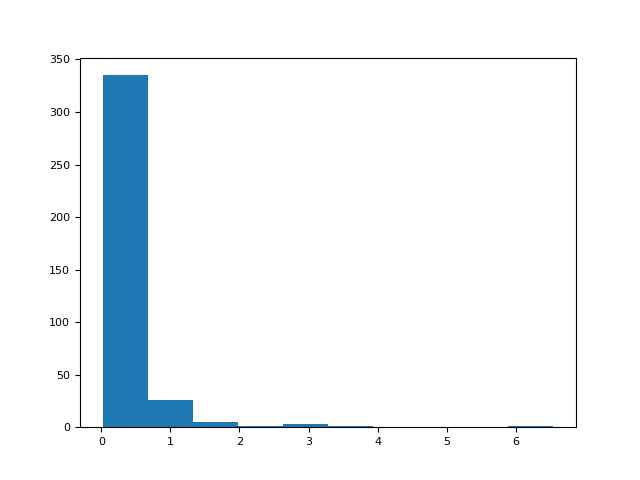

In [153]:
fig,ax=plt.subplots(1,1)
ax.hist(units.query('sliding_rp_SI.isna() and sliding_rp_IBL==1')['firing_rate'])

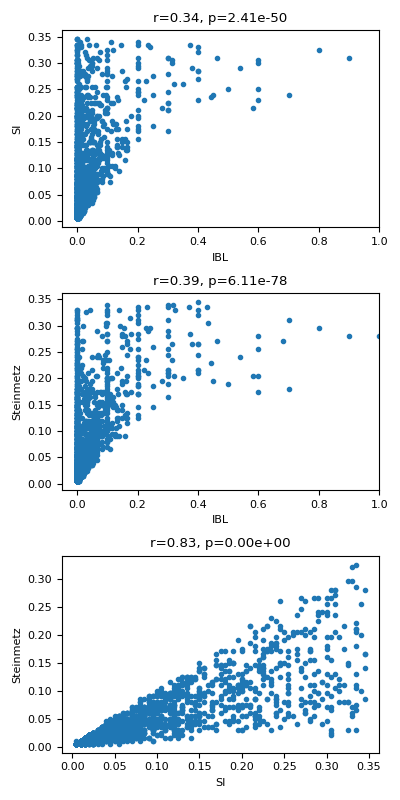

In [168]:
fig,ax=plt.subplots(3,1,figsize=(4,8))
notnan_ind=~np.isnan(units['sliding_rp_IBL'].values) & ~np.isnan(units['sliding_rp_SI'].values)
ax[0].plot(units['sliding_rp_IBL'],units['sliding_rp_SI'],'.')
r,p=stats.pearsonr(units['sliding_rp_IBL'].iloc[notnan_ind],units['sliding_rp_SI'].iloc[notnan_ind])
ax[0].set_xlabel('IBL')
ax[0].set_ylabel('SI')
ax[0].set_xlim([-0.05,1])
ax[0].set_title(f'r={r:.2f}, p={p:.2e}')

notnan_ind=~np.isnan(units['sliding_rp_IBL'].values) & ~np.isnan(units['sliding_rp_steinmetz'].values)
ax[1].plot(units['sliding_rp_IBL'],units['sliding_rp_steinmetz'],'.')
r,p=stats.pearsonr(units['sliding_rp_IBL'].iloc[notnan_ind],units['sliding_rp_steinmetz'].iloc[notnan_ind])
ax[1].set_xlabel('IBL')
ax[1].set_ylabel('Steinmetz')
ax[1].set_xlim([-0.05,1])
ax[1].set_title(f'r={r:.2f}, p={p:.2e}')

notnan_ind=~np.isnan(units['sliding_rp_SI'].values) & ~np.isnan(units['sliding_rp_steinmetz'].values)
ax[2].plot(units['sliding_rp_SI'],units['sliding_rp_steinmetz'],'.')
r,p=stats.pearsonr(units['sliding_rp_SI'].iloc[notnan_ind],units['sliding_rp_steinmetz'].iloc[notnan_ind])
ax[2].set_xlabel('SI')
ax[2].set_ylabel('Steinmetz')
ax[2].set_title(f'r={r:.2f}, p={p:.2e}')

fig.tight_layout()


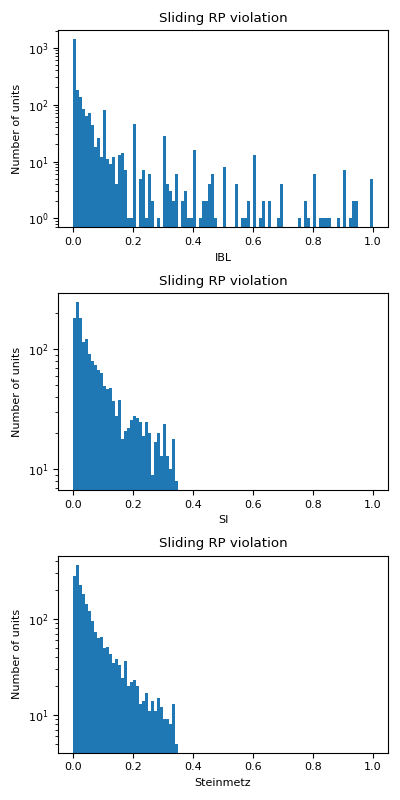

In [173]:
fig,ax=plt.subplots(3,1,figsize=(4,8))

ax[0].hist(units['sliding_rp_IBL'],bins=np.arange(0,1.01,0.01))
ax[0].set_xlabel('IBL')
ax[0].set_ylabel('Number of units')
ax[0].set_title('Sliding RP violation')
#make y log scale
ax[0].set_yscale('log')

ax[1].hist(units['sliding_rp_SI'],bins=np.arange(0,1.01,0.01))
ax[1].set_xlabel('SI')
ax[1].set_ylabel('Number of units')
ax[1].set_title('Sliding RP violation')
#make y log scale
ax[1].set_yscale('log')

ax[2].hist(units['sliding_rp_steinmetz'],bins=np.arange(0,1.01,0.01))
ax[2].set_xlabel('Steinmetz')
ax[2].set_ylabel('Number of units')
ax[2].set_title('Sliding RP violation')
#make y log scale
ax[2].set_yscale('log')

fig.tight_layout()


Text(0.5, 1.0, 'Fraction of units passing different RP violation metrics')

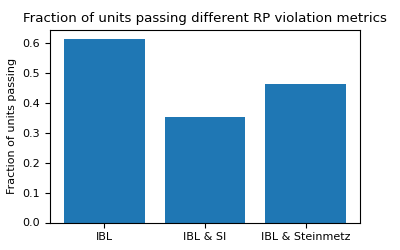

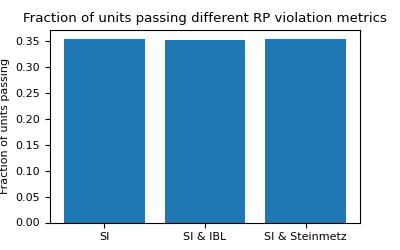

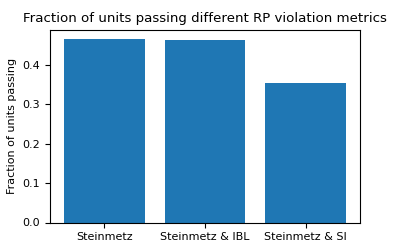

In [180]:
#IBL, SI, Steinmetz RP violation passing comparison

#how many IBL passing units also pass SI and Steinmetz RP violation metric
total_units=len(units)
ibl_pass_units=units.query('sliding_rp_pass_fail_IBL==1')
ibl_pass_fraction=len(ibl_pass_units)/total_units

#how many IBL passing units also pass SI RP violation metric
ibl_and_si_pass_units=ibl_pass_units.query('sliding_rp_SI<0.1')
ibl_and_si_pass_fraction=len(ibl_and_si_pass_units)/total_units

#how many IBL passing units also pass Steinmetz RP violation metric
ibl_and_steinmetz_pass_units=ibl_pass_units.query('sliding_rp_steinmetz<0.1')
ibl_and_steinmetz_pass_fraction=len(ibl_and_steinmetz_pass_units)/total_units

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(['IBL','IBL & SI','IBL & Steinmetz'],[ibl_pass_fraction,ibl_and_si_pass_fraction,ibl_and_steinmetz_pass_fraction])
ax.set_ylabel('Fraction of units passing')
ax.set_title('Fraction of units passing different RP violation metrics')

#how many SI passing units also pass IBL and Steinmetz RP violation metric
si_pass_units=units.query('sliding_rp_SI<0.1')
si_pass_fraction=len(si_pass_units)/total_units

#how many SI passing units also pass IBL RP violation metric
si_and_ibl_pass_units=si_pass_units.query('sliding_rp_pass_fail_IBL==1')
si_and_ibl_pass_fraction=len(si_and_ibl_pass_units)/total_units

#how many SI passing units also pass Steinmetz RP violation metric
si_and_steinmetz_pass_units=si_pass_units.query('sliding_rp_steinmetz<0.1')
si_and_steinmetz_pass_fraction=len(si_and_steinmetz_pass_units)/total_units

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(['SI','SI & IBL','SI & Steinmetz'],[si_pass_fraction,si_and_ibl_pass_fraction,si_and_steinmetz_pass_fraction])
ax.set_ylabel('Fraction of units passing')
ax.set_title('Fraction of units passing different RP violation metrics')


#how many Steinmetz passing units also pass IBL and SI RP violation metric
steinmetz_pass_units=units.query('sliding_rp_steinmetz<0.1')
steinmetz_pass_fraction=len(steinmetz_pass_units)/total_units

#how many Steinmetz passing units also pass IBL RP violation metric
steinmetz_and_ibl_pass_units=steinmetz_pass_units.query('sliding_rp_pass_fail_IBL==1')
steinmetz_and_ibl_pass_fraction=len(steinmetz_and_ibl_pass_units)/total_units

#how many Steinmetz passing units also pass SI RP violation metric
steinmetz_and_si_pass_units=steinmetz_pass_units.query('sliding_rp_SI<0.1')
steinmetz_and_si_pass_fraction=len(steinmetz_and_si_pass_units)/total_units

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.bar(['Steinmetz','Steinmetz & IBL','Steinmetz & SI'],[steinmetz_pass_fraction,steinmetz_and_ibl_pass_fraction,steinmetz_and_si_pass_fraction])
ax.set_ylabel('Fraction of units passing')
ax.set_title('Fraction of units passing different RP violation metrics')


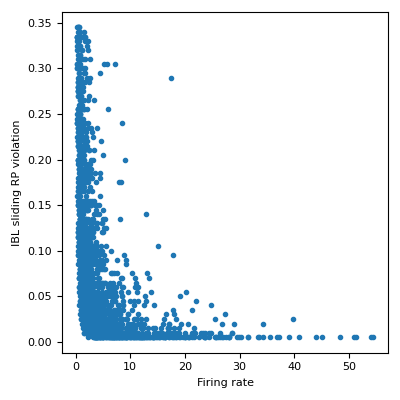

In [182]:
#plot si pr violation vs firing rate
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(units['firing_rate'],units['sliding_rp_SI'],'.')
ax.set_xlabel('Firing rate')
ax.set_ylabel('IBL sliding RP violation')
fig.tight_layout()

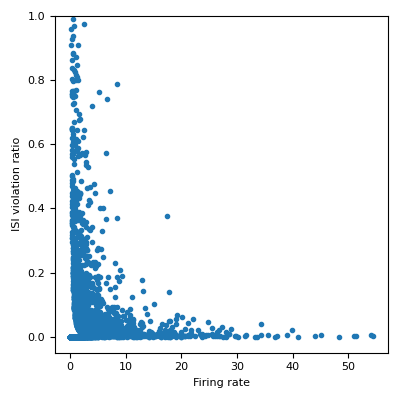

In [187]:
#plot si pr violation vs firing rate
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(units['firing_rate'],units['isi_violations_ratio'],'.')
ax.set_ylim([-0.05,1])
ax.set_xlabel('Firing rate')
ax.set_ylabel('ISI violation ratio')
fig.tight_layout()